# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

[![Python 3.7](https://img.shields.io/badge/python-3.7-blue.svg)](https://www.python.org/downloads/release/python-360/)
[![Actions Status](https://github.com/KIC/pandas-ml-qunat/workflows/Python%20package/badge.svg)](https://github.com/KIC/pandas-ml-qunat/actions?query=branch%3Amaster)


This is the root repository of the follwoing 3 core components:

* [pandas-ml-common](../pandas-ml-common/Readme.md) - a more general utilities and monkey patched pandas objects provider
* [pandas-ml-quant](../pandas-ml-quant/Readme.md) - provides technical analysis inidcators, plots, loss functions, etc.
* [pandas-ml-utils](../pandas-ml-utils/Readme.md) - apply statistical or ml models directly to data frames

You will also find an integration test module which is used mainly for testing but may also serve as a source of documentation.

Last but not least there are some notebooks which I use for my experiments feel free to use them as well. 

## Installation
Currenty all 3 libraries are very much entangled. This dependency will weaken up as we reach stablity. Never the less it is possible to only use `pandas-ml-utils` together with `pandas-ml-common`.

```bash
pip install pandas-ml-common pandas-ml-utils pandas-ml-quant
```

## Demonstration of all 3 libraries used together
### First import needed objects

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

automatically imported pandas_ml_utils 0.1.1


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


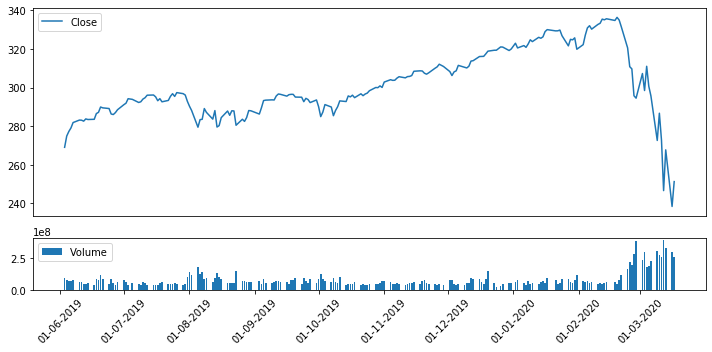

In [2]:
df = pd.fetch_yahoo("SPY").loc[:'2020-03-17']

# NOTE the access to the q_uant property
df[-200:].q.ta_plot(figsize=(10, 5))()

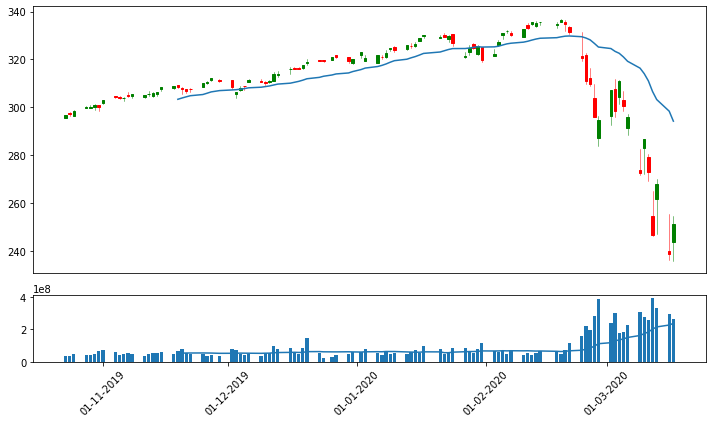

In [3]:
plt = df[-100:].q.ta_plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].q.ta_sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].q.ta_sma(period=20), panel=1)

### Now think of a predictive model
Lets say we want to predict in which quantile of a bolliner bands indicator the price in the future will be:
* 0 means below lower band
* 1 means in the middle band
* 2 means above the upper band


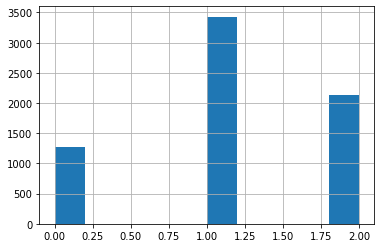

In [4]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].q.ta_future_bband_quantile(5, 5).hist()

And we want to predict this event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [5]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].q.ta_macd(),
        lambda df: df["Close"].q.ta_apo(),
        lambda df: df["Close"].q.ta_rsi(),
        lambda df: df["Close"].q.ta_roc(),
        lambda df: df["Close"].q.ta_trix(),
        lambda df: df["Close"].q.ta_ppo(),
        lambda df: df["Close"].pct_change().q.ta_zscore() / 4.,
        lambda df: df["Close"].q.ta_week_day(),
        lambda df: df["Close"].q.ta_week(),
        lambda df: df["Close"].q.ta_up_down_volatility_ratio(),
        lambda df: df.q.ta_adx(), 
        lambda df: df.q.ta_atr(),
        lambda df: df.q.ta_tr(),
        lambda df: df.q.ta_williams_R(),
        lambda df: df.q.ta_ultimate_osc(),
        lambda df: df.q.ta_bop(),
        lambda df: df.q.ta_cci(),
    ],
    labels=[
        lambda df: df["Close"].q.ta_future_bband_quantile(5, 5)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
(features, req_samples), labels, targets, weights = df.ml.extract(fnl)
features.describe()

RuntimeError: (RuntimeError(RuntimeError(TypeError("ta_cci() got an unexpected keyword argument 'relative'"), "error while calling <function <lambda> at 0x7f0236dad8c8>(['df']) whith arguments [              Open    High     Low   Close       Volume  Dividends  \\\nDate                                                                 \n1993-01-29   26.32   26.32   26.19   26.30    1003200.0        0.0   \n1993-02-01   26.32   26.49   26.32   26.49     480500.0        0.0   \n1993-02-02   26.47   26.56   26.41   26.54     201300.0        0.0   \n1993-02-03   26.58   26.84   26.56   26.82     529400.0        0.0   \n1993-02-04   26.92   26.99   26.62   26.94     531500.0        0.0   \n...            ...     ...     ...     ...          ...        ...   \n2020-03-11  279.06  280.29  269.30  272.76  255316300.0        0.0   \n2020-03-12  254.50  265.10  246.23  246.66  392220700.0        0.0   \n2020-03-13  261.55  269.89  247.07  267.75  329566100.0        0.0   \n2020-03-16  239.77  255.40  235.97  238.45  297240000.0        0.0   \n2020-03-17  243.61  254.67  235.68  251.32  262070500.0        0.0   \n\n            Stock Splits  \nDate                      \n1993-01-29           0.0  \n1993-02-01           0.0  \n1993-02-02           0.0  \n1993-02-03           0.0  \n1993-02-04           0.0  \n...                  ...  \n2020-03-11           0.0  \n2020-03-12           0.0  \n2020-03-13           0.0  \n2020-03-16           0.0  \n2020-03-17           0.0  \n\n[6832 rows x 7 columns]], {}"), "error while calling <function extract_feature_labels_weights at 0x7f028e1f82f0>(['df', 'features_and_labels']) whith arguments [              Open    High     Low   Close       Volume  Dividends  \\\nDate                                                                 \n1993-01-29   26.32   26.32   26.19   26.30    1003200.0        0.0   \n1993-02-01   26.32   26.49   26.32   26.49     480500.0        0.0   \n1993-02-02   26.47   26.56   26.41   26.54     201300.0        0.0   \n1993-02-03   26.58   26.84   26.56   26.82     529400.0        0.0   \n1993-02-04   26.92   26.99   26.62   26.94     531500.0        0.0   \n...            ...     ...     ...     ...          ...        ...   \n2020-03-11  279.06  280.29  269.30  272.76  255316300.0        0.0   \n2020-03-12  254.50  265.10  246.23  246.66  392220700.0        0.0   \n2020-03-13  261.55  269.89  247.07  267.75  329566100.0        0.0   \n2020-03-16  239.77  255.40  235.97  238.45  297240000.0        0.0   \n2020-03-17  243.61  254.67  235.68  251.32  262070500.0        0.0   \n\n            Stock Splits  \nDate                      \n1993-01-29           0.0  \n1993-02-01           0.0  \n1993-02-02           0.0  \n1993-02-03           0.0  \n1993-02-04           0.0  \n...                  ...  \n2020-03-11           0.0  \n2020-03-12           0.0  \n2020-03-13           0.0  \n2020-03-16           0.0  \n2020-03-17           0.0  \n\n[6832 rows x 7 columns], FeaturesAndLabels([<function <lambda> at 0x7f0236ef7950>, <function <lambda> at 0x7f0236ef7400>, <function <lambda> at 0x7f0236dad048>, <function <lambda> at 0x7f0236dad0d0>, <function <lambda> at 0x7f0236dad2f0>, <function <lambda> at 0x7f0236dad378>, <function <lambda> at 0x7f0236dad488>, <function <lambda> at 0x7f0236dad268>, <function <lambda> at 0x7f0236dad400>, <function <lambda> at 0x7f0236dad510>, <function <lambda> at 0x7f0236dad598>, <function <lambda> at 0x7f0236dad620>, <function <lambda> at 0x7f0236dad6a8>, <function <lambda> at 0x7f0236dad730>, <function <lambda> at 0x7f0236dad7b8>, <function <lambda> at 0x7f0236dad840>, <function <lambda> at 0x7f0236dad8c8>], [<function <lambda> at 0x7f0236dad9d8>], None, None)], {}"), "error while calling FeaturesAndLabels([<function <lambda> at 0x7f0236ef7950>, <function <lambda> at 0x7f0236ef7400>, <function <lambda> at 0x7f0236dad048>, <function <lambda> at 0x7f0236dad0d0>, <function <lambda> at 0x7f0236dad2f0>, <function <lambda> at 0x7f0236dad378>, <function <lambda> at 0x7f0236dad488>, <function <lambda> at 0x7f0236dad268>, <function <lambda> at 0x7f0236dad400>, <function <lambda> at 0x7f0236dad510>, <function <lambda> at 0x7f0236dad598>, <function <lambda> at 0x7f0236dad620>, <function <lambda> at 0x7f0236dad6a8>, <function <lambda> at 0x7f0236dad730>, <function <lambda> at 0x7f0236dad7b8>, <function <lambda> at 0x7f0236dad840>, <function <lambda> at 0x7f0236dad8c8>], [<function <lambda> at 0x7f0236dad9d8>], None, None)(['self', 'df', 'extractor']) whith arguments [              Open    High     Low   Close       Volume  Dividends  \\\nDate                                                                 \n1993-01-29   26.32   26.32   26.19   26.30    1003200.0        0.0   \n1993-02-01   26.32   26.49   26.32   26.49     480500.0        0.0   \n1993-02-02   26.47   26.56   26.41   26.54     201300.0        0.0   \n1993-02-03   26.58   26.84   26.56   26.82     529400.0        0.0   \n1993-02-04   26.92   26.99   26.62   26.94     531500.0        0.0   \n...            ...     ...     ...     ...          ...        ...   \n2020-03-11  279.06  280.29  269.30  272.76  255316300.0        0.0   \n2020-03-12  254.50  265.10  246.23  246.66  392220700.0        0.0   \n2020-03-13  261.55  269.89  247.07  267.75  329566100.0        0.0   \n2020-03-16  239.77  255.40  235.97  238.45  297240000.0        0.0   \n2020-03-17  243.61  254.67  235.68  251.32  262070500.0        0.0   \n\n            Stock Splits  \nDate                      \n1993-01-29           0.0  \n1993-02-01           0.0  \n1993-02-02           0.0  \n1993-02-03           0.0  \n1993-02-04           0.0  \n...                  ...  \n2020-03-11           0.0  \n2020-03-12           0.0  \n2020-03-13           0.0  \n2020-03-16           0.0  \n2020-03-17           0.0  \n\n[6832 rows x 7 columns]], {}")

Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


In [ ]:
features, lags = df.model.feature_selection(fnl)

In [ ]:
features

Now Lets have a closer look at this features - we try to see distinct clusters.

In [ ]:
df.model.plot_features(
    FeaturesAndLabels(
        features=[
            lambda df: df["Close"].q.ta_week_day(),
            lambda df: df.q.ta_adx()[["ADX"]], 
            lambda df: df.q.ta_atr(),
            lambda df: df.q.ta_bop(),
            lambda df: df.q.ta_cci(),
        ],
        labels=[
            lambda df: df["Close"].q.ta_future_bband_quantile(5, 5, stddev=2.0)

        ],
        targets=[
            lambda df: df["Close"].q.ta_bbands(5, stddev=2.0)[["lower", "upper"]]
        ]
    )
)

Ideally we should see that there is some pattern which can seperate the features per label (color). 

So now we can build up a model from the learnings we have made. To make it a little more interesting we could use crossvalidation i.e. a K-Folds algorithm.

In [ ]:
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.data.splitting.sampeling import KFoldBoostRareEvents, KEquallyWeightEvents

fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42, alpha=2.0),
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    lambda df: df["Close"].q.ta_week_day(),
                    lambda df: df.q.ta_adx()[["ADX"]], 
                    lambda df: df.q.ta_atr(),
                    lambda df: df.q.ta_bop(),
                    lambda df: df.q.ta_cci(),
                ],
                lambda df: df.q.ta_rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].q.ta_future_bband_quantile(5, 5, stddev=2.0).q.ta_one_hot_encode_discrete()

            ],
            targets=[
                lambda df: df["Close"].q.ta_bbands(5, stddev=2.0)[["lower", "upper"]]
            ]
        ),
        summary_provider=ClassificationSummary,
    ),
    RandomSplits(cross_validation=(1, KFoldBoostRareEvents(3).split))
)

fit

This obviously is not the besst model but you got the Idea. Also not the quite large penalization term which is "engineered" by trail and error. However One could also use the Hyperparameter optimization possibility:

```python
fit = df.model.fit(
    SkModel(...),
    test_size=0.4,
    test_validate_split_seed=42,
    hyper_parameter_space={'alpha': hp.choice('alpha', [0.0001, 10]), 'max_iter': 50,
                           '__max_evals': 4, '__rstate': np.random.RandomState(42)}
```

The leading `__` is used as a prefix for parameters passed to [hyperopt](https://github.com/hyperopt/hyperopt). All other parameters are passed to the model, like `max_iter` or `alpha` are parameters passed to the sklearn MLClassifier.

Ok now if we want to know what the current prediction is for the next 5 days, we simply call

```python
df.model.predict(fit.model)[-1:]["prediction"]
# [[6.13729022e-06, 9.99999839e-01, 1.07792629e-08]]
```

Oh wait now we know that we expect the price to be in the middle band but what does this actually mean? Which values are the middle band?
This is where the target comes into play.

In [ ]:
df.model.predict(fit.model, tail=3).map_prediction_to_target()

### Saving and Loading
Of corse we can save and load this model and just apply it to the data frame.

In [ ]:
fit.model.save("/tmp/readme_model.dill")
model2 = Model.load("/tmp/readme_model.dill")
df.model.predict(model2, tail=1)